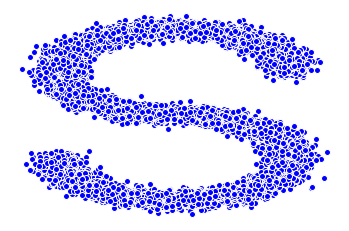

In [9]:
#1.获取数据集
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import make_s_curve
import torch
# 制造图像 的数据集
s_curve,_ = make_s_curve(10**4,noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0
# 1000*2，进行把点放缩
data =s_curve.T
# 这样就变成（2*1000）
fig,ax =plt.subplots()
ax.scatter(*data,color='blue',edgecolor='white')
ax.axis('off')
datasets = torch.Tensor(s_curve).float()

#2.确定超参数

In [11]:
num_steps=100
#这是设置经过100此变换
betas  = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5

#计算alpha等其他的，是1-beta
alphas =1-betas
alphas_prod = torch.cumprod(alphas,0)
# xt-1,不包括最后一个
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)
alphas_bar_sqrt=torch.sqrt(alphas_prod_p)
one_minus_alphas_bar_log = torch.log(1-alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


# 3.计算扩散过程qx

In [12]:
def q_x(x_0,t):
    """

    :param x_0:
    :param t:
    :return: √ax0+√1-az,z是噪声
    """
    noise =torch.randn_like(x_0)
    alphas_t =alphas_bar_sqrt[t]
    alphas_1_m_t =one_minus_alphas_bar_sqrt[t]
    return (alphas_t*x_0+alphas_1_m_t*noise)

# 4.进行扩散表演

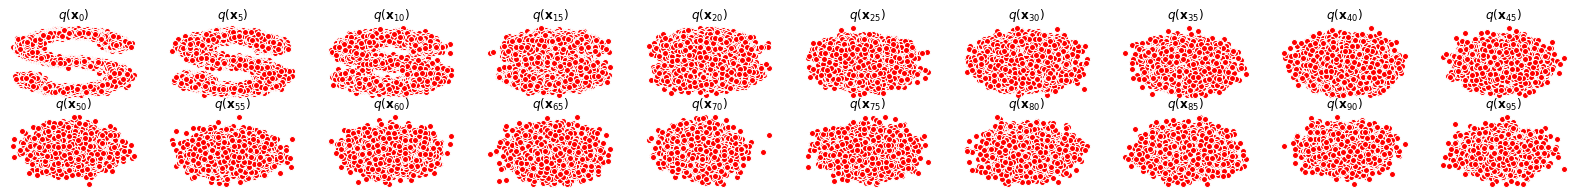

In [15]:
num_show = 20
fig,ax =plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')
for i in range(num_show):
    j = i//10
    k = i%10
    q_i = q_x(datasets,num_steps*i//num_show)
    #生成t时刻的数据
    ax[j,k].scatter(q_i[:,0],q_i[:,1],color ='red',edgecolor='white')
    ax[j,k].set_axis_off()
    ax[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_show)+'})$')

# 5.你扩散过程，是应用mlp来解决

In [16]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128):
        super(MLPDiffusion,self).__init__()
        self.linears = nn.ModuleList([
            nn.Linear(2,num_units),
            nn.ReLU(),
            nn.Linear(num_units,num_units),
            nn.ReLU(),
            nn.Linear(num_units,num_units),
            nn.ReLU(),
            nn.Linear(num_units,2),
        ])
        self.step_embeddings=nn.ModuleList([
            nn.Embedding(n_steps,num_units),
            nn.Embedding(n_steps,num_units),
            nn.Embedding(n_steps,num_units),
        ])

    def forward(self,x,t):
        for idx ,embedding_layer in enumerate(self.step_embeddings):
            t_embedding =embedding_layer(t)
            #把时间也传入进去，使用embedding
            x=self.linears[2*idx](x)
            x+=t_embedding
            x = self.linears[2*idx+1](x)
        x=self.linears[-1](x)
        return x

# 6s损失函数的构建

In [17]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = x_0.shape[0]
    #对每一个batch生成随机时刻
    t =torch.randint(0,n_steps,size=(batch_size//2,))
    t=torch.cat([t,n_steps-1-t],dim=0)
    t=t.unsqueeze(-1)

    a=alphas_bar_sqrt[t]

    aml = one_minus_alphas_bar_sqrt[t]

    noise =torch.randn_like(x_0)
    x=x_0*a+noise*aml

    output = model(x,t.squeeze(-1))
    # model 目标是生成最小的误差noise，通过x和时间t
    return (noise-output).square().mean()


# 7.Tuili函数的编写
$ \mathbf{x}_{t-1}=\frac{1}{\sqrt{\alpha_{t}}}\left(\mathbf{x}_{t}-\frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \boldsymbol{\epsilon}_{\theta}\left(\mathbf{x}_{t}, t\right)\right)+\sigma_{t} \mathbf{Z}$
![](https://files.catbox.moe/u9qez2.png)

In [18]:
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)
    x_seq =[cur_x]

    for i in reversed(range(n_steps)):
        #反向生成
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)

    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    '''
    从T时刻的采样值重构t时间的xt
    :param model:
    :param x:
    :param t:
    :param betas:
    :param one_minus_alphas_bar_sqrt:
    :return:
    '''
    t = torch.tensor([t])
    coeff =betas[t]/one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x,t)

    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))\

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()

    sample = mean + sigma_t * z

    return (sample)

8. 开始训练

Training model...
tensor(0.3338, grad_fn=<MeanBackward0>)
tensor(0.4133, grad_fn=<MeanBackward0>)
tensor(0.5100, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

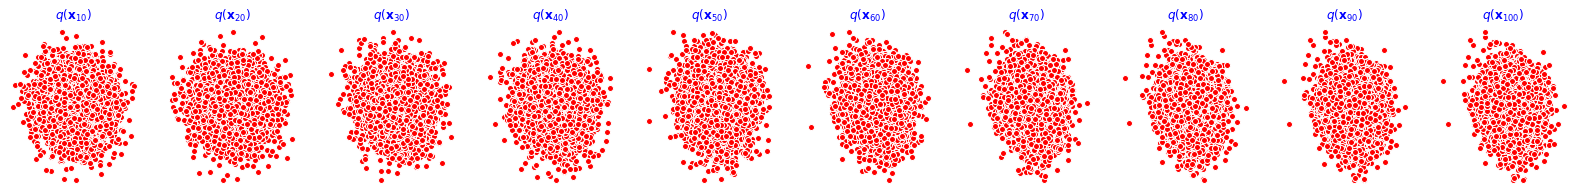

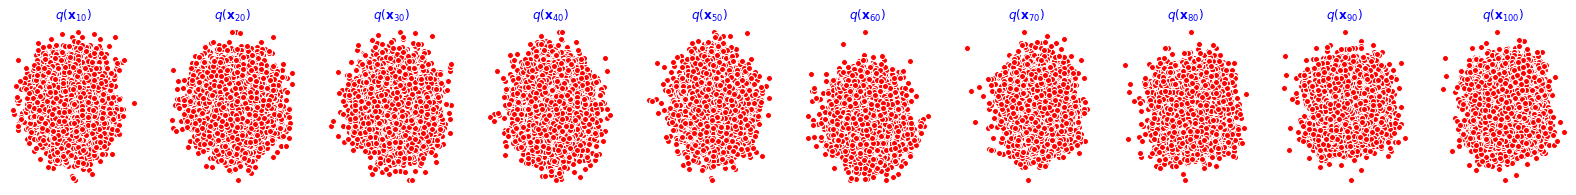

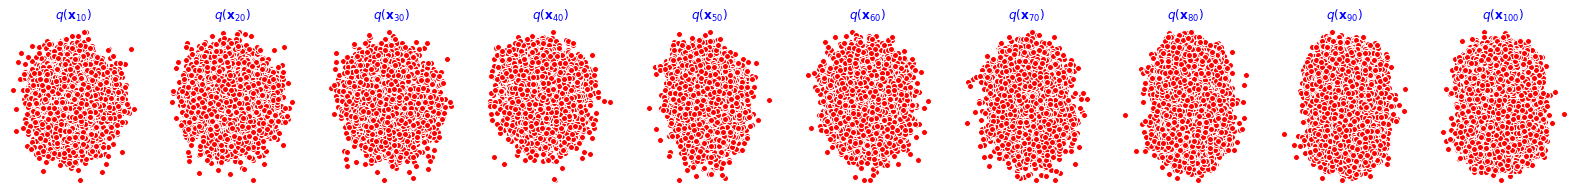

In [19]:
seed = 1234

class EMA():
    """构建一个参数平滑器"""
    def __init__(self,mu=0.01):
        self.mu = mu
        self.shadow = {}

    def register(self,name,val):
        self.shadow[name] = val.clone()

    def __call__(self,name,x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0-self.mu)*self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

print('Training model...')
# 开始训练模型，加载
batch_size = 128
dataloader = torch.utils.data.DataLoader(datasets,batch_size=batch_size,shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)#输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()

    if(t%100==0):
        print(loss)
        # 构建恢复的图
        x_seq = p_sample_loop(model,datasets.shape,num_steps,betas,one_minus_alphas_bar_sqrt)

        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')
